This script allows yout to genereate your own dataset with your own camera (In this case most likely your build-in laptop camera will be used)

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from IPython.display import clear_output

def capture_and_preprocess_image_combined():
    cap = cv2.VideoCapture(0)
    
    cap.set(cv2.CAP_PROP_BRIGHTNESS, 85) 
    cap.set(cv2.CAP_PROP_CONTRAST, 21) 
    cap.set(cv2.CAP_PROP_SATURATION, 66) 
    cap.set(cv2.CAP_PROP_HUE, 40)
    
    if not cap.isOpened():
        raise IOError("Cannot open webcam")

    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise IOError("Cannot capture image from webcam")

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    original_frame = frame.copy()

    # Noise reduction and grayscale
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    
    # Thresholding to find contours
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Adjust to square
        side_length = max(w, h)
        center_x = x + w // 2
        center_y = y + h // 2
        square_x = max(center_x - side_length // 2, 0)
        square_y = max(center_y - side_length // 2, 0)
        square_x_end = min(square_x + side_length, frame.shape[1])
        square_y_end = min(square_y + side_length, frame.shape[0])
        
        # Crop to the square
        cropped_frame = frame[square_y:square_y_end, square_x:square_x_end]

        # Resize to fit the model input
        resized_frame = cv2.resize(cropped_frame, (32, 32), interpolation=cv2.INTER_AREA)
    else:
        resized_frame = cv2.resize(frame, (32, 32), interpolation=cv2.INTER_AREA)

    clear_output(wait=True)
    plt.imshow(resized_frame, cmap='gray')
    plt.axis('off')
    plt.show()
    
    normalized_resized_frame = resized_frame.astype('float32') / 255.0

    return normalized_resized_frame

def append_save_data(images, labels, directory, label):
    if not os.path.exists(directory):
        os.makedirs(directory)

    images_path = os.path.join(directory, "images.npy")
    labels_path = os.path.join(directory, "labels.npy")

    # Load existing data if it exists
    if os.path.exists(images_path) and os.path.exists(labels_path):
        existing_images = np.load(images_path)
        existing_labels = np.load(labels_path)
        images = np.concatenate((existing_images, images))
        labels = np.concatenate((existing_labels, labels))

    # Save updated arrays
    np.save(images_path, images)
    np.save(labels_path, labels)
    print(f"Data successfully appended and saved to disk at {directory}")

def collect_data_for_cifar(class_label):
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    if class_label not in classes:
        print("Invalid class label. Please enter a valid CIFAR-10 class name.")
        return
    
    label_index = classes.index(class_label)
    num_iterations = 10
    delay = 5
    save_interval = 10
    collected_images = []
    collected_labels = []

    for i in range(num_iterations):
        try:
            processed_image = capture_and_preprocess_image_combined()
            collected_images.append(processed_image)
            collected_labels.append(label_index)  # Append the label index instead of name
            print(f"Data collected for {class_label}: {i + 1}/{num_iterations}")
        except Exception as e:
            print(f"Failed to capture image on iteration {i + 1} for {class_label}: {str(e)}")
            continue

        if (i + 1) % save_interval == 0 or i == num_iterations - 1:
            append_save_data(np.array(collected_images), np.array(collected_labels), f"CIFAR_DATA/{class_label}", class_label)
            collected_images, collected_labels = [], []  # Reset the lists after saving
        time.sleep(delay)

def load_data(directory="dataset"):
    images = np.load(os.path.join(directory, "images.npy"))
    labels = np.load(os.path.join(directory, "labels.npy"))
    print("Data loaded from disk.")
    return images, labels

if __name__ == '__main__':
    class_label = input("Enter the label for the images to be captured (e.g., frog, truck): ")
    time.sleep(5)
    collect_data_for_cifar(class_label)


## Show the created images

Data loaded from disk.


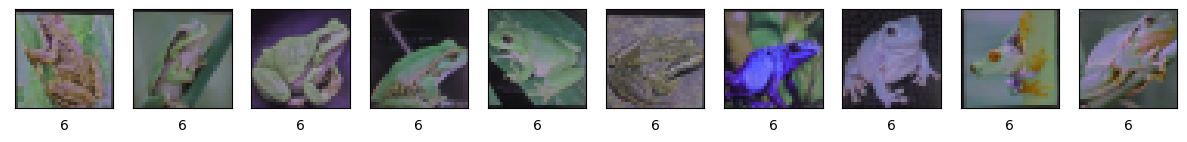

In [8]:

def plot_images(images, labels, num_images=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

if __name__ == "__main__":
    directory = input("Enter the directory where the images and labels are stored: ")
    images, labels = load_data(f"CIFAR_DATA/{directory}")
    if images is not None and labels is not None:
        plot_images(images, labels)

In [24]:
new_images_frog, new_labels_frog = load_data("CIFAR_DATA/frog")
new_images_car, new_labels_car = load_data("CIFAR_DATA/automobile")

Data loaded from disk.
Data loaded from disk.


Show augmentations of created data that is performed to prevent overfitting

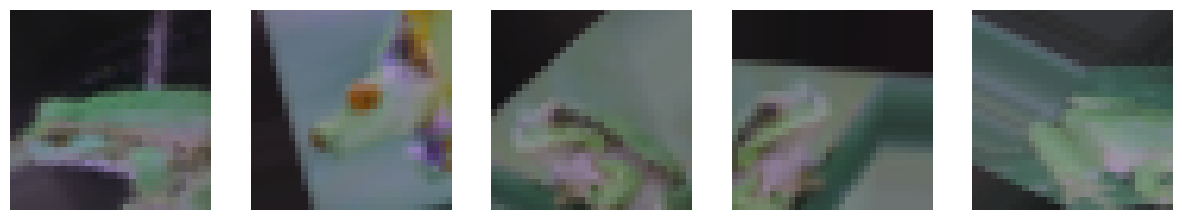

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

new_images_frog, new_labels_frog = resample(
    new_images_frog,
    new_labels_frog,
    replace=True,  # sample with replacement
    n_samples=1000,  # to match a larger dataset size, adjust according to your needs
    random_state=123) 

# Create an instance of ImageDataGenerator with desired augmentations
data_generator = ImageDataGenerator(
    rotation_range=20,       # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    shear_range=0.2,         # apply shearing transformation
    zoom_range=0.2,          # randomly zoom into images
    horizontal_flip=True,    # randomly flip images
    fill_mode='nearest'      # fill in new pixels created by rotation or width/height shift
)

# Assuming 'new_images_frog' is your dataset with shape (num_samples, 32, 32, 3)
data_generator.fit(new_images_frog)

# Example to visualize some augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Generate batches of augmented images from the dataset
    img = data_generator.flow(new_images_frog, batch_size=1).next()[0]
    axes[i].imshow(img)  # Ensure correct type and display
    axes[i].axis('off')
plt.show()